In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set the notebook parameters, the path to the key file and change working-directory to the root directory of the dataprocessing framework.

In [2]:
import os
base_dir = '/local/scratch/toolkit/'
os.environ['EXOT_ACCESS_DIR'] = str(base_dir + "benchmark_platforms_access/")
os.chdir(base_dir + 'datapro')
print("Working directory: " + str(os.getcwd()))
print("Key directory set to: " + str(os.environ['EXOT_ACCESS_DIR']))

Working directory: /local/scratch/toolkit/datapro
Key directory set to: /local/scratch/toolkit/benchmark_platforms_access/


Import all necessary packages.

In [3]:
np.set_printoptions(linewidth=120)
plt.rcParams["figure.figsize"] = (18,10)
plt.rcParams["legend.loc"] = "lower right"

import toml    as TOML              # TOML library to handle config files
import pandas  as pd                # Pandas for data manipulation
import seaborn as sb                # Statistical data visualisation
import pathlib as PATH              # Used to convert strings to path objects for (de-)serialisation
import types   as tp                # Library used for online method development

# scikit-learn packets
import sklearn.base                 #
import sklearn.svm                  # LinearSVC, SVC
import sklearn.pipeline             # make_pipeline
import sklearn.preprocessing        # StandardScaler
import sklearn.decomposition        # PCA
import sklearn.naive_bayes          # GaussianNB
import sklearn.metrics              # CM

# Toolkit packets
import exot                       # Dataprocessing
import exot.experiment            # Experiment for execution
import exot.util                  # General utilities
import exot.layer                 # Data manipulation layers
from exot.util       import *
from exot.layer      import *
from exot.channel    import *
from exot.experiment import *

# Plotting
from exot.plotting.experiment_plotter import *
from exot.plotting.run_plotter        import *

Parameters

In [4]:
NB_EXPERIMENT_TYPES = ["performance", "interference"]
NB_CHANNELS = ["ff", "fp", "fr"]
NB_CONFIGS = ["flush+flush", "flush+prefetch", "flush+reload"]

#### Notebook config

In [5]:
# Names to configure
NB_EXPERIMENT_TYPE = "performance"
NB_CONFIG = "flush+flush"

# Generated names
NB_EXPERIMENT = f"{NB_CONFIG}-cc_{NB_EXPERIMENT_TYPE}"
NB_CHANNEL = "f" + NB_CONFIG.split("+")[-1][0]

In [6]:
print("NB_CHANNEL         ", NB_CHANNEL)
print("NB_EXPERIMENT_TYPE ", NB_EXPERIMENT_TYPE)
print("NB_CONFIG          ", NB_CONFIG)
print("NB_EXPERIMENT      ", NB_EXPERIMENT)

NB_CHANNEL          ff
NB_EXPERIMENT_TYPE  performance
NB_CONFIG           flush+flush
NB_EXPERIMENT       flush+flush-cc_performance


In [7]:
assert NB_EXPERIMENT_TYPE in NB_EXPERIMENT_TYPES
assert NB_CHANNEL in NB_CHANNELS
assert NB_CONFIG in NB_CONFIGS

# Generate Experiment
1. Load the configuration and define phases and environments

In [8]:
config = TOML.load(f"configurations/{NB_EXPERIMENT}.toml")
print(TOML.dumps(config))

environments_to_execute = [
    "ARMv8",
    "Haswell"
]

phases = {
    "ARMv8": {
        "short": ["trainShortARMv8", "evalShortARMv8"],
        "normal": ["trainARMv8", "evalARMv8"],
    },
    "Haswell": {
        "short": ["trainShortHaswell", "evalShortHaswell"],
        "normal": ["trainHaswell", "evalHaswell"],
    },
}

name = "flush+flush-cc_performance"
save_path = "./data"
backup_path = "./data/_backup"
experiment_exists_action = "move"

[EXPERIMENT]
type = "PerformanceExperiment"
channel = "Cache"

[EXPERIMENT.GENERAL]
latency = 10
fan = true
governors = "userspace"
frequencies = "max"
sampling_period = 2e-5
delay_after_spawn = 5.0
delay_after_auxiliary = 1.0
active_wait = false

[EXPERIMENT.PHASES.trainShortARMv8]
bit_count = 1500
symbol_rates = "[100] + (list(range(500, 6001, 500)))"
repetitions = 2

[EXPERIMENT.PHASES.evalShortARMv8]
bit_count = 5000
symbol_rates = "[100] + (list(range(500, 6001, 500)))"
repetitions = 2

[EXPERIMENT.PHASES.trainARMv8]
bit_count = 1500
symbol_rates = "[100] + (list(range(250, 6001, 250)))"
repetitions = 5

[EXPERIMENT.PHASES.evalARMv8]
bit_count = 5000
symbol_rates = "[100] + (list(range(250, 6001, 250)))"
repetitions = 5

[EXPERIMENT.PHASES.trainShortHaswell]
bit_count = 1500
symbol_rates = "[100] + (list(range(10000, 78001, 10000)) + [78125])"
repetitions = 2


2. Instantiate, generate and write the experiment

In [9]:
raise Exception("Are you sure?")

Exception: Are you sure?

In [ ]:
channel = ChannelFactory()(config["EXPERIMENT"]["channel"])
experiment = ExperimentFactory()(config["EXPERIMENT"]["type"], config=config, channel=channel)

experiment.generate()
experiment.print_duration()

# If exists...
if PATH.Path(f"data/{NB_EXPERIMENT}/").exists():
    # First move...
    experiment.config.experiment_exists_action = "move"
    experiment.write()

# Then set to update mode.
experiment.config.experiment_exists_action = "update"
experiment.write()

## Execute

Running `execute` will execute in all environments present in the configuration.

Show phases' durations.

In [ ]:
experiment.print_duration()

_Optionally_ peek at execution status. The execution status can be modified manually or via `_modify_execution_status`. If a modification has been made, push it to run instances with `_push_execution_status`. To rerun or resume execution, set the _resume_ argument to `True`.

In [ ]:
execution_status = getattr(experiment, "_execution_status", {})

for _platform in phases:
    for phase, runs in execution_status.items():
        for run, statuses in runs.items():
            for platform, status in statuses:
                if _platform == platform and _platform in phase:
                    print(
                        "{}Phase: {:>20s} Run: {:3d} Platform: {:>8s} Status: {}".format(
                            "✓ " if any(status) else "✗ ", phase, run, platform, status
                        )
                    )

Finally, execute sequentially in all environments.

In [ ]:
raise Exception("Are you sure?")

In [ ]:
for env in environments_to_execute:
    experiment.execute_in_environment(env, phases[env]['short'], resume=False)
    experiment.execute_in_environment(env, phases[env]['normal'], resume=False)
experiment.write()

## Analyse

1. Define which class of experiments to analyse (short of normal length)

In [10]:
SHORT = False

2. Check data collection status

In [11]:
for _experiment in [NB_EXPERIMENT]:
    for _platform, _phase_mapping in phases.items():
        for _class, _phases in _phase_mapping.items():
            for _phase in _phases:
                _log_folders = !ls -d data/$_experiment/$_phase*/$_platform 2>/dev/null | wc -l
                _logs = !ls -d data/$_experiment/$_phase*/$_platform/**.csv 2>/dev/null | wc -l
                print("experiment:", _experiment, "platform:", _platform, "phase:", _phase,
                      "folders:", _log_folders[0].strip(), "logs:", _logs[0].strip(), sep=" ")

experiment: flush+flush-cc_performance platform: ARMv8 phase: trainShortARMv8 folders: 13 logs: 52
experiment: flush+flush-cc_performance platform: ARMv8 phase: evalShortARMv8 folders: 13 logs: 52
experiment: flush+flush-cc_performance platform: ARMv8 phase: trainARMv8 folders: 25 logs: 250
experiment: flush+flush-cc_performance platform: ARMv8 phase: evalARMv8 folders: 25 logs: 250
experiment: flush+flush-cc_performance platform: Haswell phase: trainShortHaswell folders: 9 logs: 36
experiment: flush+flush-cc_performance platform: Haswell phase: evalShortHaswell folders: 9 logs: 36
experiment: flush+flush-cc_performance platform: Haswell phase: trainHaswell folders: 80 logs: 800
experiment: flush+flush-cc_performance platform: Haswell phase: evalHaswell folders: 80 logs: 800


3. Deserialisation

In [12]:
path_to_serialised_experiment = PATH.Path(f"data/{NB_EXPERIMENT}/_experiment.pickle")
experiment = PerformanceExperiment.read(path_to_serialised_experiment, replace=False)

2019-09-10 13:33:24 :: unpicked an experiment instance <PerformanceExperiment at 0x7f31ccd4cf60 with Cache channel, configured>
2019-09-10 13:33:25 :: git commit of unpickled experiment repo 'ae015e07' does not match the commit in which the unpickling was performed '50fd78bb'


4. Specify the demo run and visualise

In [13]:
DEMO_PHASE = "trainShortARMv8"
DEMO_ID = 0
DEMO_ARM = "ARM" in DEMO_PHASE

In [14]:
ingest_args = dict(
    lne={
        "decision_device": sklearn.pipeline.make_pipeline(
            sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
        )
    },
    rdp={"sampling_period": experiment.environment_config_general("ARMv8")["sampling_period"]}
    if DEMO_ARM
    else {},
    io={
        "env": "ARMv8" if DEMO_ARM else "Haswell",
        "rep": 0,
        "matcher": exot.util.wrangle.Matcher("cache", NB_CHANNEL, ["access_time"], list(range(64))),
    },
)

In [15]:
demo_run = experiment.phases[DEMO_PHASE][DEMO_ID]
demo_run.ingest(**ingest_args)

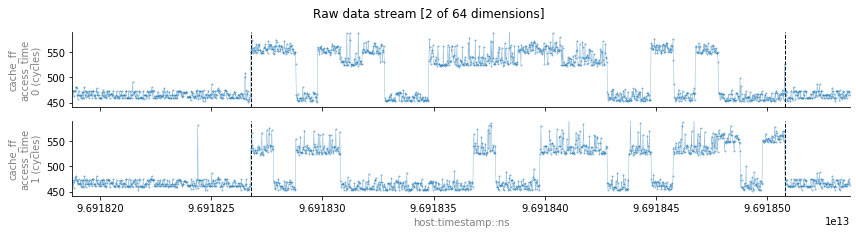

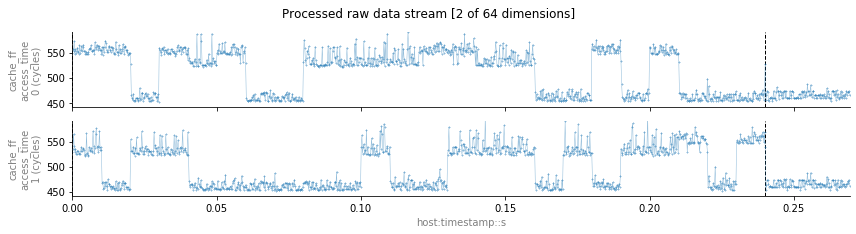

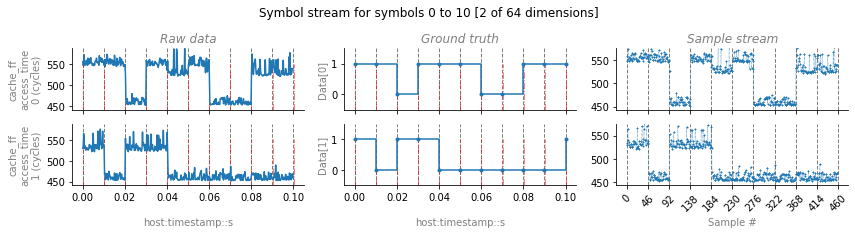

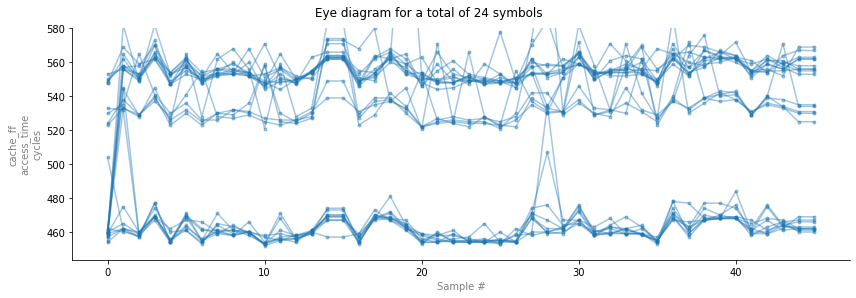

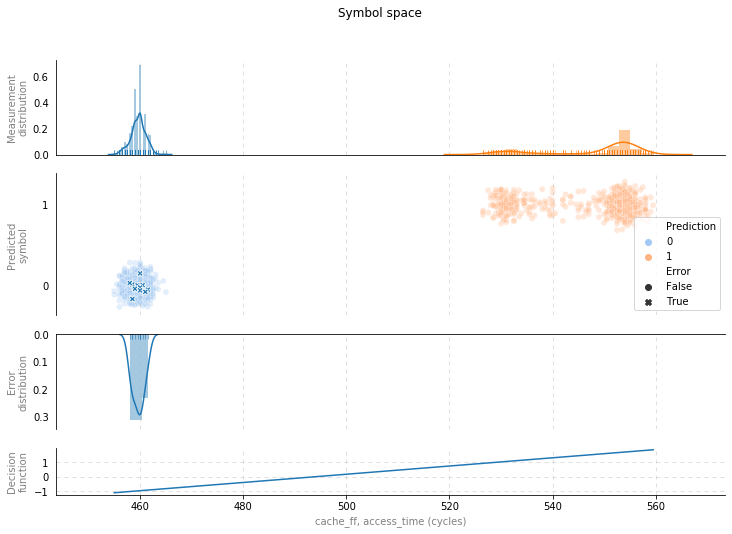

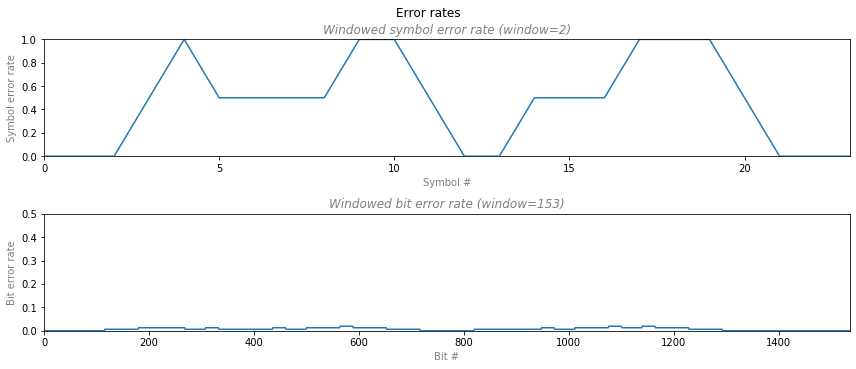

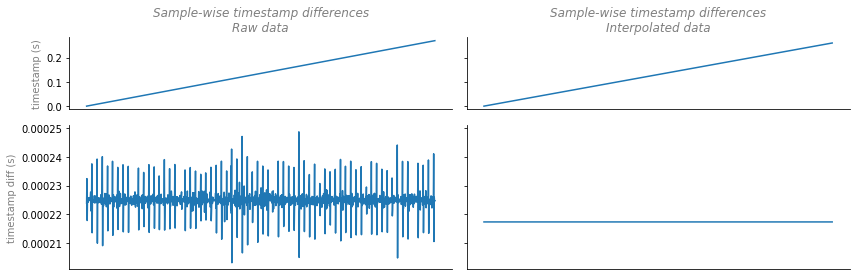

In [16]:
with PerformanceRunPlotter(demo_run) as plotter:
    plotter.plot_rawstream(dim_count=2)
    plotter.plot_rdpstream(end=5.0, dim_count=2)
    plotter.plot_slicing(dim_count=2)
    plotter.plot_eye_diagram()
    plotter.plot_symbol_space()
    plotter.plot_error()
    plotter.plot_timing()

5. Analyse the experiment

_Define the analysis arguments and phase mappings_

In [17]:
to_evaluate = "short" if SHORT else "normal"

analysis_args = {
    "ARMv8": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        rdp={"sampling_period": experiment.environment_config_general("ARMv8")["sampling_period"]},
        io={
            "matcher": exot.util.wrangle.Matcher(
                "cache", NB_CHANNEL, ["access_time"], list(range(64))
            )
        },
    ),
    "Haswell": dict(
        lne={
            "decision_device": sklearn.pipeline.make_pipeline(
                sklearn.preprocessing.StandardScaler(), sklearn.svm.LinearSVC()
            )
        },
        io={
            "matcher": exot.util.wrangle.Matcher(
                "cache", NB_CHANNEL, ["access_time"], list(range(64))
            )
        },
    ),
}

phase_mappings = {
    "ARMv8": {
        "short": ["trainShortARMv8", "evalShortARMv8"],
        "normal": ["trainARMv8", "evalARMv8"],
    },
    "Haswell": {
        "short": ["trainShortHaswell", "evalShortHaswell"],
        "normal": ["trainHaswell", "evalHaswell"],
    },
}

_Calculate the performance metrics_

In [18]:
del experiment.performance_metricsance_metrics

In [19]:
for env in phase_mappings:
    experiment.calculate_performance_metrics(
        phase_mapping=dict([tuple(phase_mappings[env][to_evaluate])]),
        envs=[env],
        reps=[],
        **analysis_args[env],
    )

2019-09-10 13:34:18 :: analysing performance for phases: trainARMv8 -> evalARMv8
2019-09-10 13:34:18 :: \_ analysing performance for env: ARMv8
2019-09-10 13:34:25 :: \_ analysing performance for env: ARMv8
2019-09-10 13:34:32 :: \_ analysing performance for env: ARMv8
2019-09-10 13:34:39 :: \_ analysing performance for env: ARMv8
2019-09-10 13:34:45 :: \_ analysing performance for env: ARMv8
2019-09-10 13:34:51 :: \_ analysing performance for env: ARMv8
2019-09-10 13:34:57 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:03 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:10 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:16 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:23 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:30 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:37 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:44 :: \_ analysing performance for env: ARMv8
2019-09-10 13:35:51 :: \_ analysing p

_Show the performance metrics..._

In [24]:
experiment.performance_metrics.head()

,phase,trained_with,environment,bit_rate,symbol_rate,repetition,bit_error,symbol_error,matcher,variable
0,trainARMv8,,ARMv8,6400.0,100,0,0.005859,0.37500,"<Matcher quantity='cache', method='ff', values...",cache_ff
1,evalARMv8,trainARMv8,ARMv8,6400.0,100,0,0.006725,0.43038,"<Matcher quantity='cache', method='ff', values...",cache_ff
2,trainARMv8,,ARMv8,6400.0,100,1,0.005859,0.37500,"<Matcher quantity='cache', method='ff', values...",cache_ff
3,evalARMv8,trainARMv8,ARMv8,6400.0,100,1,0.006725,0.43038,"<Matcher quantity='cache', method='ff', values...",cache_ff
4,trainARMv8,,ARMv8,6400.0,100,2,0.005859,0.37500,"<Matcher quantity='cache', method='ff', values...",cache_ff


_...and the aggregated performance metrics (mean of repetitions)_

In [21]:
experiment.aggregate_performance_metrics()

,phase,trained_with,environment,bit_rate,symbol_rate,matcher,variable,bit_error,symbol_error
0,evalARMv8,trainARMv8,ARMv8,6400.0,100,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.006725,0.430380
1,evalARMv8,trainARMv8,ARMv8,16000.0,250,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.008109,0.516456
2,evalARMv8,trainARMv8,ARMv8,32000.0,500,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.011353,0.465823
3,evalARMv8,trainARMv8,ARMv8,48000.0,750,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.098695,0.602532
4,evalARMv8,trainARMv8,ARMv8,64000.0,1000,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.023220,0.706329
5,evalARMv8,trainARMv8,ARMv8,80000.0,1250,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.016139,0.625316
6,evalARMv8,trainARMv8,ARMv8,96000.0,1500,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.056131,0.754430
7,evalARMv8,trainARMv8,ARMv8,112000.0,1750,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.050672,0.802532
8,evalARMv8,trainARMv8,ARMv8,128000.0,2000,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.138964,0.903797
9,evalARMv8,trainARMv8,ARMv8,144000.0,2250,"<Matcher quantity='cache', method='ff', values...",cache_ff,0.143236,0.908861


7. Serialise the experiment with the calculated performance metrics

In [27]:
experiment.write()

8. Get aggregated performance metrics for each environment and phase and output as CSV

In [26]:
for env in phase_mappings:
    eval_phase = phase_mappings[env][to_evaluate][-1]
    BERs = wrangle.filter_data(
        experiment.aggregate_performance_metrics(), environment=env, phase=eval_phase
    )

    PREFIX = NB_CHANNEL.upper() + ("_INT_" if NB_EXPERIMENT_TYPE == "interference" else "")

    pd.DataFrame({"bit_rate": BERs["bit_rate"], "bit_error": BERs["bit_error"]}).to_csv(
        "./data/BER_{}_{}_{}.dat".format(PREFIX, eval_phase, env),
        sep=",",
        encoding="utf-8",
        index=False,
    )

9. Plot performance metrics

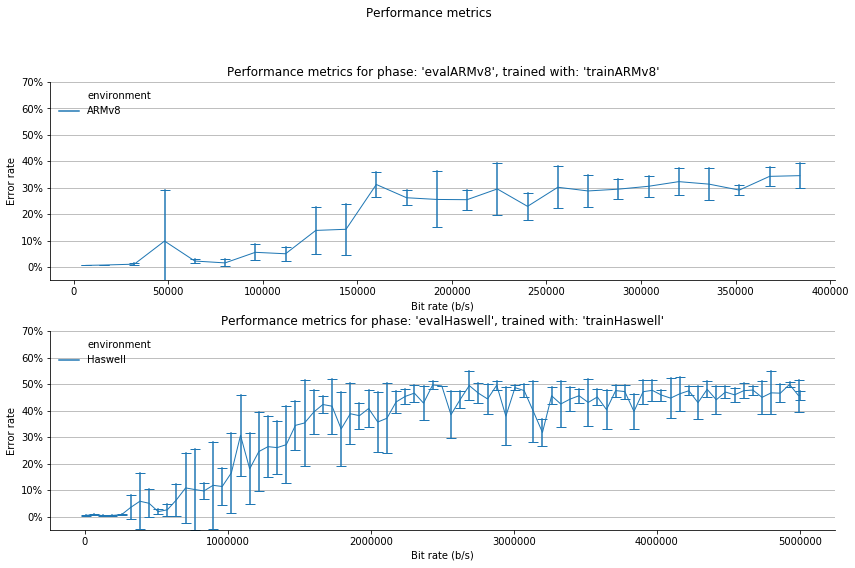

In [25]:
with PerformanceExperimentPlotter(experiment) as plotter:
    plotter.plot_performance_metrics()